<a href="https://colab.research.google.com/github/harshitbhavnani/Deep-Learning/blob/main/DeepLearning_J076_Exp11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout,Flatten, Lambda
from keras.layers import Conv2D, Activation,AveragePooling2D,MaxPooling2D
from keras.optimizers import RMSprop

from keras import backend as K

from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random

In [55]:
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [56]:
def create_pairs(x, digit_indices):
  
  num_classes=10
  
  pairs = []
  labels = []
  
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
  
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)

In [57]:
def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(32, (3,3), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(64, (3,3), activation = 'tanh')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(64,activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(10,activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  
  return model

In [58]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
# input_shape = (1, 28, 28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)

(60000, 28, 28, 1)


In [59]:
# create training+test positive and negative pairs

num_classes=10

digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_net(input_shape)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0   

In [60]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [74]:
print(tr_pairs.dtype)
print(tr_y.dtype)
print(te_pairs.dtype)
print(te_y.dtype)

float32
float64
float32
int64


In [75]:
tr_y = tr_y.astype('float64')
tr_pairs = tr_pairs.astype('float64')
te_pairs = te_pairs.astype('float64')
te_y = te_y.astype('float64')

In [76]:
epochs=20

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 145s 170ms/step - loss: 0.0993 - accuracy: 0.8951 - val_loss: 0.0539 - val_accuracy: 0.9564
Epoch 2/20
847/847 [==============================] - 143s 168ms/step - loss: 0.0879 - accuracy: 0.9132 - val_loss: 0.0499 - val_accuracy: 0.9622
Epoch 3/20
847/847 [==============================] - 143s 169ms/step - loss: 0.0807 - accuracy: 0.9254 - val_loss: 0.0470 - val_accuracy: 0.9638
Epoch 4/20
847/847 [==============================] - 143s 169ms/step - loss: 0.0728 - accuracy: 0.9386 - val_loss: 0.0434 - val_accuracy: 0.9592
Epoch 5/20
847/847 [==============================] - 145s 171ms/step - loss: 0.0668 - accuracy: 0.9427 - val_loss: 0.0425 - val_accuracy: 0.9555
Epoch 6/20
847/847 [==============================] - 147s 174ms/step - loss: 0.0639 - accuracy: 0.9471 - val_loss: 0.0388 - val_accuracy: 0.9613
Epoch 7/20
847/847 [==============================] - 145s 171ms/step - loss: 0.0629 - accuracy: 0.9486 - val_loss: 0.0368 -

In [77]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('Accuracy on test set: %0.2f%%' % (100 * te_acc))

Accuracy on training set: 99.12%
Accuracy on test set: 97.67%


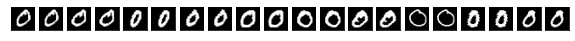

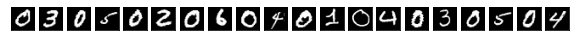

[0.00147853]
[0.48665833]
[0.00544047]
[0.92894846]
[0.00079062]
[0.14471427]
[0.01037862]
[0.8433658]
[0.00985081]
[0.51038975]
[0.00090439]
[1.5831139]
[0.00464336]
[1.3474752]
[0.00132337]
[1.4275571]
[0.01770457]
[1.5324625]
[0.01449929]
[1.1627566]


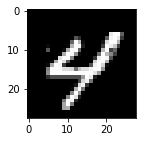

In [78]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 20
import tensorflow as tf

im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

for i in range(number_of_items):
  print(y_pred[i])
plt.figure(figsize=(20, 2))
plt.imshow(im, cmap="gray")
plt.show()